## Setup

- Working directory: Project Root Directory
- Required Packages: google-cloud-storage

In [1]:
import os
import json
import logging

from pathlib import Path
from google.cloud import storage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from tqdm.contrib.concurrent import thread_map
from tqdm import tqdm

In [2]:
# Settings.

JSON_FILES = ["diagrams_wo_text_20200131.ndjson", "diagrams_20200131.ndjson"]
BUCKET_NAME = "digital_ink_diagram_data"
LOCAL_DATA_DIR = "data/didi"
MAX_WORKERS = 8

In [ ]:
def download_blob(blob):
    blob.download_to_filename(str(Path(LOCAL_DATA_DIR, blob.name))
    print(f'Downloaded {blob.name}')

In [ ]:
def download_all():
    # Google Storage Client
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name=BUCKET_NAME)
    
    # Make data directory if not exists
    Path(LOCAL_DATA_DIR, 'dot').mkdir(parents=True, exist_ok=True)
    Path(LOCAL_DATA_DIR, 'png').mkdir(parents=True, exist_ok=True)
    Path(LOCAL_DATA_DIR, 'xdot').mkdir(parents=True, exist_ok=True)
    
    blobs = [blob for blob in bucket.list_blobs()]
    
    thread_map(download_blob, blobs, max_workers=MAX_WORKERS)

In [ ]:
download_all()

In [ ]:
## data/didi/images/{label_id}.png

# Convert drawing strokes to an image
# Test playground


ax = plt.gca()
ax.set_aspect("equal")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

Path(f'{LOCAL_DATA_DIR}/images').mkdir(exist_ok=True)
count = 0
with open(os.path.join(LOCAL_DATA_DIR, JSON_FILES[0])) as f:
    for line in f:
        ink = json.loads(line)
        plt.clf()
        for s in ink["drawing"]:
            plt.plot(s[0], [y for y in s[1]], color="red")
        plt.savefig(f'{LOCAL_DATA_DIR}/images/{ink["label_id"]}.png')
        if count > 0:
            break
        count += 1

In [ ]:
from matplotlib import pyplot as plt
import json

ax = plt.gca()
ax.set_aspect("equal")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

Path(f'{LOCAL_DATA_DIR}/images').mkdir(exist_ok=True)
with open(os.path.join(LOCAL_DATA_DIR, JSON_FILES[0])) as f:
    for line in f:
        ink = json.loads(line)
        plt.clf()
        for s in ink["drawing"]:
            plt.plot(s[0], [y for y in s[1]], color="red")
        plt.savefig(f'{LOCAL_DATA_DIR}/images/{ink["label_id"]}.png')

In [ ]:
## data/didi/classes.txt

# List distinct classes
import pydot

graphs = pydot.graph_from_dot_file('data/didi/xdot/0007d1d60eb54be62f50d7d8bc384f41010c9009.xdot')

graph = graphs[0]

# from IPython.display import Image, display
# plt = Image(graph.create_png())
# display(plt)


# graph.get_bb()
node = graph.get_node('0')[0]
dir(node)
node.get_shape()

In [ ]:
## Match node ids from png and xdot folders

from os import listdir
from pathlib import Path

png_dir = f'{LOCAL_DATA_DIR}/png'
png_set = set()
for fname in listdir(png_dir):
    png_set.add(str(Path(fname).with_suffix('')))

In [ ]:
from os import listdir
from pathlib import Path

xdot_dir = f'{LOCAL_DATA_DIR}/xdot'
xdot_set = set()
for fname in listdir(xdot_dir):
    xdot_set.add(str(Path(fname).with_suffix('')))

In [ ]:
png_set == xdot_set

In [4]:
from matplotlib import pyplot as plt
import json
from tqdm import tqdm

ax = plt.gca()
ax.set_aspect("equal")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ink_set = set()
Path(f'{LOCAL_DATA_DIR}/images').mkdir(exist_ok=True)
with open(os.path.join(LOCAL_DATA_DIR, JSON_FILES[0])) as file:
    lines = file.readlines()
    for line in tqdm(reversed(lines)):
        ink = json.loads(line)
        plt.clf()
        if ink['label_id'] in ink_set:
            continue

        ink_set.add(ink['label_id'])
        for s in ink["drawing"]:
            plt.plot(s[0], [y for y in s[1]], color="red")
        plt.savefig(f'{LOCAL_DATA_DIR}/images/{ink["label_id"]}.png')

36368it [00:42, 865.07it/s] 


<Figure size 640x480 with 0 Axes>

  3%|██▌                                                                                 | 1131/36368 [00:00<00:08, 4055.71it/s]


'Saved ...'

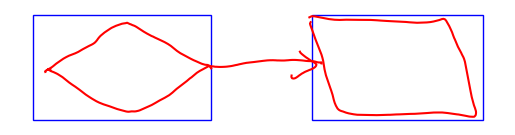

In [8]:
# Displays prompt images with drawing overlaid.

import pydot

def get_label_file(type, labelid):
    file_id = os.path.join(type, "%s.%s" % (labelid, type))
    fname = os.path.join(LOCAL_DATA_DIR, file_id)
    if os.path.exists(fname):
        return fname
    return fname


def PrepareDrawing():
    plt.clf()
    plt.axes().set_aspect("equal")
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().axis('off')

    
def display_image(ink):
#     im = plt.imread(os.path.join(LOCAL_DATA_DIR, "png", ink["label_id"] + ".png"))
    # Compute scaling of the image.
    guide_width = ink["writing_guide"]["width"]
    guide_height = ink["writing_guide"]["height"]
#     im_height, im_width, _ = im.shape
    graph = pydot.graph_from_dot_file(f'data/didi/xdot/{ink["label_id"]}.xdot')[0]
    bb = [float(coord) for coord in graph.get_bb().strip('"').split(',')]
    im_width, im_height = bb[2] - bb[0], bb[3] - bb[1]
#     wscale = guide_width / (bb[3] - bb[1])
#     hscale = guide_height / (bb[2] - bb[0])
    scale=min(guide_width / im_width, guide_height / im_height)
    offset_x = (guide_width - scale * im_width) / 2
    offset_y = (guide_height - scale * im_height) / 2
#     print(guide_width, guide_height)
    
    for node in graph.get_nodes():
        shape = node.get_shape()
        if shape is not None:
            pos = [float(coord) for coord in node.get_pos().strip('"').split(',')]
            cw = offset_x + scale * (im_width - pos[0])
            ch = offset_y + scale * (im_height - pos[1])
            bbscale = 400/0.8
            bbw, bbh = float(node.get_width()) * bbscale, float(node.get_height()) * bbscale
            rectangle = patches.Rectangle((cw - bbw/2, ch - bbh/2), bbw, bbh, 
                             linewidth=1, edgecolor='b', facecolor='none')
            plt.gca().add_patch(rectangle)

    
def display_strokes(ink):
    for s in ink["drawing"]:
        plt.plot(s[0], [y for y in s[1]], color="red")

        
def display_ink(ink):
    # Fetch the corresponding PNG image.
    get_label_file("png", ink["label_id"])
    # Draw image, overlay strokes.
    PrepareDrawing()
    display_image(ink)
    display_strokes(ink)
#     print(f'Saving {LOCAL_DATA_DIR}/images/{ink["label_id"]}.png')
    plt.savefig(f'{LOCAL_DATA_DIR}/images/{ink["label_id"]}.png', bbox_inches='tight')


Path(f'{LOCAL_DATA_DIR}/images').mkdir(exist_ok=True)
for json_file in JSON_FILES:
    count = 0
    with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
        lines = f.readlines()
        for line in tqdm(lines):
            ink = json.loads(line)
            if ink['label_id'] == '0564aa8ca586f2e93661d1e26d4f5d7babbb382f':
                display_ink(ink)
                break
        break
                
'Saved ...'

In [ ]:
next(iter(png_set))

In [ ]:
match_count = 0
nomatch_count = 0
with open(os.path.join(LOCAL_DATA_DIR, JSON_FILES[0])) as f:
    for line in tqdm(f):
        ink = json.loads(line)
        plt.clf()
        if ink['label_id'] in png_set:
            match_count += 1
        else:
            nomatch_count += 1
            
match_count, nomatch_count

In [ ]:
len(png_set)

In [ ]:
'0007d1d60eb54be62f50d7d8bc384f41010c9009' in png_set

In [ ]:
from matplotlib import pyplot as plt
import json
from tqdm import tqdm

ax = plt.gca()
ax.set_aspect("equal")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

Path(f'{LOCAL_DATA_DIR}/images').mkdir(exist_ok=True)
ink_set = set()
for json_file in JSON_FILES:
    with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
        for line in tqdm(f):
            ink = json.loads(line)
            ink_id = ink['label_id']
            ink_set.add(ink_id)
            
len(ink_set)

In [ ]:
# Set the frame for stroking
fig = plt.Figure()
ax = fig.add_subplot(111)
#     ax.set_aspect("equal")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

# Ensure output directory exists
Path(LOCAL_DATA_DIR, 'images').mkdir(parents=True, exist_ok=True)

# When there are multiple drawings for a single label, we pick the first one.
ink_set = set()

# Parse the files to collect drawings
for json_file in JSON_FILES:
    count = 0
    with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
        for line in tqdm(f):
            ink = json.loads(line)
            ink_id = ink['label_id']

            if ink_id in ink_set:
                # Only process the first drawing with the label.
                continue
            ink_set.add(ink_id)

            # Draw the strokes now
            ax.clear()
            ax.axis('off')
            w, h = ink['writing_guide']['width'], ink['writing_guide']['height']
            ax.set_xlim(0, w)
            ax.set_ylim(0, h)

            for s in ink["drawing"]:
                ax.plot(s[0], [y for y in s[1]], color="black")

            # Parse xdot file
            graph = pydot.graph_from_dot_file(str(Path(
                LOCAL_DATA_DIR, 'xdot', ink['label_id']).with_suffix('.xdot')))[0]
            bb = [float(coord) for coord in graph.get_bb().strip('"').split(',')]
            wscale = w / (bb[3] - bb[1])
            hscale = h / (bb[2] - bb[0])
            for node in graph.get_nodes():
                pos = node.get_pos()
                if pos is not None and node.get_shape() is not None:
                    pos = [float(coord) for coord in pos.strip('"').split(',')]
                    wpos, hpos = pos[1], pos[0]
                    wnode, hnode = 5, 7.5
#                     rectangle = patches.Rectangle(
#                         (wpos - wnode/2, hpos - hnode/2), wnode, hnode, linewidth=1, edgecolor='r', facecolor='none')
                    rectangle = patches.Rectangle(
                        (wscale * (wpos - wnode/2), hscale * (hpos - hnode/2)),
                        wscale * wnode, hscale * hnode, edgecolor='r')
                    ax.add_patch(rectangle)
                    print(wscale, hscale)
                    print(wscale * (wpos - wnode/2), hscale * (hpos - hnode/2))
                    print(wscale * wnode, hscale * hnode)

            # Source: https://stackoverflow.com/a/44206924
            canvas = FigureCanvas(fig)
#                 ax.set_axis_off()
#                 fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
            canvas.print_figure(str(Path(LOCAL_DATA_DIR, 'images', ink_id).with_suffix('.png')))

            if count > 1:
                break
            else:
                count = count + 1
        break

In [ ]:
import shutil

shutil.rmtree(str(Path(LOCAL_DATA_DIR)))

In [ ]:
from didi_data import clean, download_all, ink_all_drawings

In [ ]:
clean()

In [ ]:
download_all()

In [ ]:
ink_all_drawings()

In [ ]:
# Set the frame for stroking
if False:
    fig = plt.Figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)

# Ensure output directory exists
Path(LOCAL_DATA_DIR, 'images').mkdir(parents=True, exist_ok=True)

# When there are multiple drawings for a single label, we pick the first one.
ink_set = set()
shapes_list = ['box', 'oval', 'diamond', 'octagon', 'parallelogram', 'arrow']
shapes_dict = {shape: idx for idx, shape in enumerate(shapes_list)}

# Parse the files to collect drawings
for json_file in JSON_FILES:
    with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
        for line in tqdm(f):
            ink = json.loads(line)
            ink_id = ink['label_id']

            if ink_id in ink_set:
                # Only process the first drawing with the label.
                continue
            ink_set.add(ink_id)

            # Parse xdot file
            graph = pydot.graph_from_dot_file(str(Path(
                LOCAL_DATA_DIR, 'xdot', ink['label_id']).with_suffix('.xdot')))[0]
            for node in graph.get_nodes():
                pos = node.get_pos()
                if pos is not None:
                    w, h = node.get_width(), node.get_height()
                    
                


            # Draw the strokes now
            if False:
                ax.clear()
                ax.axis('off')

                for s in ink["drawing"]:
                    ax.plot(s[0], [y for y in s[1]], color="black")

                # Source: https://stackoverflow.com/a/44206924
                canvas = FigureCanvas(fig)
                canvas.print_figure(str(Path(LOCAL_DATA_DIR, 'images', ink_id).with_suffix('.png')),
                                    bbox_inches='tight')

# Output shapes to file
with open(str(Path(LOCAL_DATA_DIR, 'shapes.txt')), 'w') as file:
    for shape in shapes_list:
        file.write(shape + '\n')

In [ ]:
import pydot

graphs = pydot.graph_from_dot_file('data/didi/xdot/0007d1d60eb54be62f50d7d8bc384f41010c9009.xdot')

graph = graphs[0]

# from IPython.display import Image, display
# plt = Image(graph.create_png())
# display(plt)

# graph.get_bb()
for node in graph.get_nodes():
    val = node.get_pos()
    if val is not None:
        print(val)
        break
#     print(dir(node))
#     break
# graph.get_size()

In [ ]:
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

image_path = str(Path(LOCAL_DATA_DIR, 'images', '40c2d065f4a3a93836d021752531fe438730b4c3.png'))  # Replace with the actual path to your PNG image

width, height = get_image_dimensions(image_path)
print(f"Width: {width}px, Height: {height}px")

In [ ]:
640/2400, 480/1432